#  Estimation of Orbital Parameters of Extra-solar Planets from Radial Velocities using Markov Chain Monte Carlo (MCMC)

## MCMC: A Conceptual Introduction

Monte Carlo (MC) methods have become a cornerstone of present-day scientific analyses by providing a simple approach for obtaining information about distributions, especially for estimating posterior distributions in Bayesian inference using samples from a continuous random variable. They comprise of a class of algorithms for sampling from a desired probability distribution. The sample of the distribution are obtained by constructing a chain that has the probability distribution as its stationary distribution followed by registering and saving the states from the chain.

The samples created by the Markov chain have probability density proportional to a known function. These large number of samples drawn are used to estimate the properties of the distribution (such as its expected value or variance). Practically, different sets of samples are created using multiple chains (an ensemble of chains), starting from a set of points randomly chosen and sufficiently separated from each other in the sample space.

These stochastic chains comprise of **walkers** which explores the parameter space in random directions according to an algorithm that looks for places with a reasonably high contribution to the properties of the probability distribution to move to the next, with higher probabilities than the direct predecessor.

MCMC is essentially a *sampler* as it explores the parameter space. The fundamental process of running a Markov chain is to compare the **models** generated by the chains against the **data** while moving around the parameter space. The objective is to determine the set of parameters that produces the best fit model of our data. The process is inherently Bayesian as opposed to *frequentist* as it requires a prior knowledge of the system in terms of the parameters. For example, constructing a stellar model can contain temperature as a parameter with a prior that the temperature at the core is within a certain range, as fusion reactions can only occur above certain temperatures.


## Bayesian Inference

We shall use the MCMC technique to know more about characteristics of the planetary system, 51 Pegasi (HD 217014). The radial velocity (RV) data was obtained from NASA Exoplanet Archive which is maintained by the [NASA Exoplanet Science](https://exoplanetarchive.ipac.caltech.edu/). Let the data be denoted by **D<sub>RV</sub>** of which we are interested to make inferences.

We want to interpret the RV data in light of an underlying model **M** which is a function of a set of parameters, **$\Theta$<sub>M</sub>**, which can predict about the proximity of the data to the model. We can, therefore, estimate the conditional probability *P* (**D<sub>RV</sub>** | **$\Theta$<sub>M</sub>**, **M**) that we would obtain the data, **D<sub>RV</sub>**, from our model using a particular set of parameters, **$\Theta$<sub>M</sub>**. Alternatively, given our model **M**, we can ask about the likelihood of the parameter **$\Theta$<sub>M</sub>** such that the assumed model completely explains our data.

In Bayesian statistical inference, we are interested in determining the quantity, *P* (**$\Theta$<sub>M</sub>** | **D<sub>RV</sub>**, **M**). It is the probability that the parameters are actually **$\Theta$<sub>M</sub>** under the assumed model given our data, **D<sub>RV</sub>**. The two conditional probabilities are related as:

 \begin{equation} \it{P}\, \mathrm{(\Theta_M\,|\,D_{RV}, M)}\; \it{P}\, \mathrm{(D_{RV}\,|\,M)} = \it{P}\, \mathrm{(\Theta_M, D_{RV}\,|\,M)} = \it{P}\, \mathrm{(D_{RV}\,|\,\Theta_M, M)}\;\, \it{P}\, \mathrm{(\Theta_M\,|\,M)} \mathrm{\tag{1}}\end{equation}
 


where $\it{P}\, \mathrm{(\Theta_M, D_{RV}\,|\,M)}$ represents the joint probability of obtaining the parameter, **$\Theta$<sub>M</sub>**, such that the data, **D<sub>RV</sub>**, is observed. From Bayes' theorem, the two conditional probabilities can be rearranged as:

 \begin{equation} \it{P}\, \mathrm{(\Theta_M\,|\,D_{RV}, M)} = \frac {\it{P}\, \mathrm{(D_{RV}\,|\,\Theta_M, M)}\;\, \it{P}\, \mathrm{(\Theta_M\,|\,M)}}{\it{P}\, \mathrm{(D_{RV}\,|\,M)}}\mathrm{\tag{2}}\end{equation}


The MCMC analysis usually starts with selection of a set of parameter values, often referred to as **priors** - $\it{P}\, \mathrm{(\Theta_M\,|\,M)}$. As the name suggests, the values are chosen based on previous measurements, physical conditions ,and other known constraints. The denominator, $\it{P}\, \mathrm{(D_{RV}\,|\,M)}$, is termed as **evidence**. It describes how well our model explains our data after averaging over the complete range of the parameter set. The model is said to be good if it matches  our data to a large extent. $\it{P}\, \mathrm{(\Theta_M\,|\,D_{RV}, M)}$ represents the **posterior**. This is a measure of our belief in the best parameter after combining our prior values with the current observations and normalizing by the evidence over the parameter space.

<img src="Image1.png" width="850" height="400">


The above process is summarized below.

 - With the set of input parameters as variables, write a function that specifies our model.
 - Set up an ensemble of walkers defined by the parameters **$\Theta$<sub>M</sub>**.
 - A grid containing the values of different parameters over their respective ranges is generated. 
 - Every walker will now begin exploring the parameter space. To do this, each walker takes a step to a new value of parameters and generates a model with that set of parameters. It then compares the model to the dataset, usually through minimizing the $\chi^2$ or maximizing the log-likelihood function.
 \begin{equation} \mathrm{Likelihood} = -\frac{1}{2} \sum_{Data}^{}{\mathrm{ln}\;\{2\pi\;({y_{Error})}^{2}}\}-\frac{1}{2} \sum_{Data}^{}{\left(\frac{y_{Data}-y_{Model}}{y_{Error}}\right)^{2}}\mathrm{\tag{3}}\end{equation}
 - The MCMC then determines the ratio of the likelihood generated by the model with the new set of parameters to data and compares it with the previous set of parameter. If the new location produces a better ratio, the walker moves there and repeats the process. If the new location is worse than the earlier, it retreats to its previous position and looks for a new direction. 
 - The walkers move around by exploring the parameter space and terminates its journey in the region of maximum likelihood.
 
A posterior distribution is generated at the end of the process (also termed as the **production run**).If the MCMC runs a sufficient number of steps,it converges to the region of maximum likelihood. 


## Fitting the Exoplanet's Radial Velocity

The RV data of 51 Pegasi can be downloaded from the Exoplanet archive. We are interested in the RV values with thier errors as a function of the Julian Date. For representation purpose, we shall phase-fold the time axis.

In [2]:
#!/usr/bin/env python3
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import math
import emcee
import corner
import pickle
import tkinter as tk
from tkinter import simpledialog
from tkinter.simpledialog import askinteger
import easygui
from IPython.display import display, Math

plt.rcParams['figure.figsize'] = [12,7]

                0          1         2
0    2.450003e+06 -28.980785  1.345139
1    2.450003e+06 -33.494823  1.467521
2    2.450003e+06 -38.008003  1.840782
3    2.450004e+06  -9.878883  1.157139
4    2.450004e+06  -2.043795  0.981048
..            ...        ...       ...
197  2.455528e+06 -34.615391  1.353431
198  2.455547e+06   5.948516  2.245812
199  2.455844e+06  25.590000  3.590000
200  2.455845e+06 -28.450001  2.820000
201  2.455847e+06  -9.530000  2.430000

[202 rows x 3 columns]


<ipython-input-3-f1e281b299ea>:7: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.errorbar(HJD, Rad_Vel, RV_Error, color='black', fmt='o', capsize=5, capthick=1, ecolor='black')


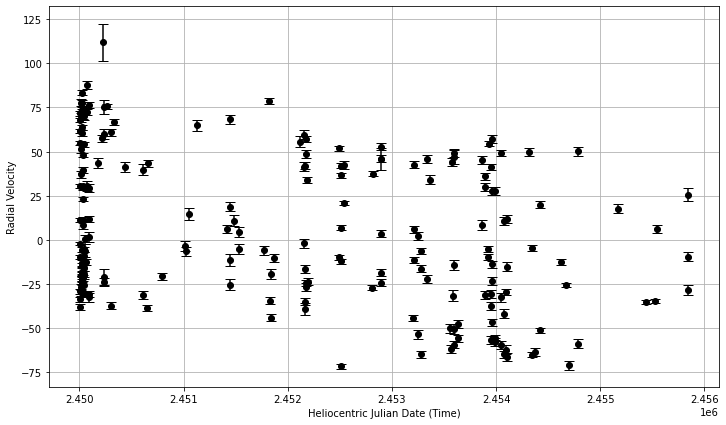

<ipython-input-3-f1e281b299ea>:45: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.errorbar(2*np.pi*Phase_Folded[:,[j]], Rad_Vel, RV_Error, color='black', fmt='o', capsize=5, capthick=1, ecolor='black')


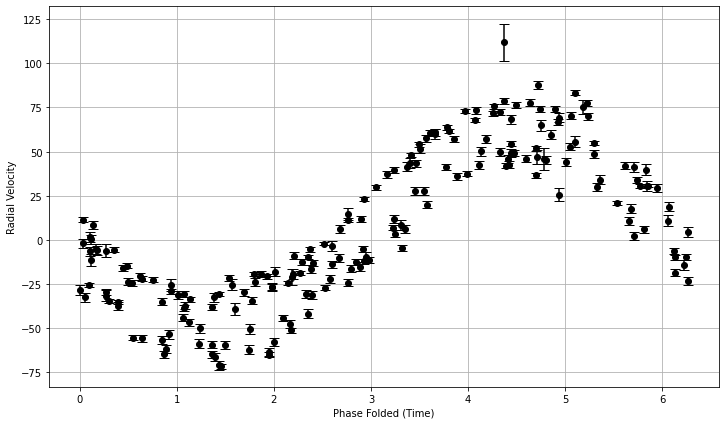

In [3]:
Data = pd.read_table('UID_0113357_RVC_005.dat',sep = '\s+',skiprows=22, header = None, index_col = None)
print(Data)
RV_Data = np.array(Data)
HJD = RV_Data[:,[0]]
Rad_Vel = RV_Data[:,[1]]
RV_Error = RV_Data[:,[2]]
plt.errorbar(HJD, Rad_Vel, RV_Error, color='black', fmt='o', capsize=5, capthick=1, ecolor='black')
plt.xlabel('Heliocentric Julian Date (Time)')
plt.ylabel('Radial Velocity')
plt.grid()
plt.show(block=False)
len_HJD = len(HJD)
Phase_Folded = np.empty((len_HJD, len_HJD))
fig = plt.figure()
for i in range(0,len_HJD):
    t = HJD
    T0 = HJD[i]
    P = 4.230785
    PF = ((t-T0)/P)-np.floor((t-T0)/P)
    Phase_Folded[:,[i]] = PF


root =tk.Tk()
canvas1 = tk.Canvas(root, width = 400, height = 200,  relief = 'raised')
canvas1.pack()

label1 = tk.Label(root, text='Select the Reference Time (Fiducial)')
label1.config(font=('helvetica', 14))
canvas1.create_window(200, 25, window=label1)

label2 = tk.Label(root, text='Input the n\u1D57\u02B0 HJD to be taken as the reference \n\n(n\u2208Z\u207a; 1 \u2264 n \u2264 202):')
label2.config(font=('helvetica', 10))
canvas1.create_window(200, 95, window=label2)
mystring =tk.IntVar(root)
def close_window():
    root.destroy()
e1 = tk.Entry(root,textvariable = mystring,width=25,fg="black",bd=3,selectbackground='gray').place(x=100, y=120)
button1 = tk.Button(root, 
                text='Submit', 
                fg='White', 
                bg= '#000000',height = 1, width = 10,command=close_window).place(x=150, y=170)
root.mainloop()
j = mystring.get() 
j = j-1
plt.errorbar(2*np.pi*Phase_Folded[:,[j]], Rad_Vel, RV_Error, color='black', fmt='o', capsize=5, capthick=1, ecolor='black')
plt.xlabel('Phase Folded (Time)')
plt.ylabel('Radial Velocity')
plt.grid()
plt.show(block=False)
x_data = Phase_Folded[:,[j]]
x_model = np.linspace(0, 1, 5000)

The radial velocity curve repeats over time and it appears to be a sinusoid. The RV method for detecting exoplanets relies on the fact that a star does not remain completely stationary when it is orbited by a planet. The star moves, ever so slightly, in a small circle or ellipse, responding to the gravitational pull of its smaller companion. When viewed from a distance, these slight movements affect the star's normal light spectrum, or color signature. The spectrum of a star that is moving towards the observer appears slightly shifted toward bluer (shorter) wavelengths. If the star is moving away, then its spectrum is shifted toward redder (longer) wavelengths. 

We define our model to be of the form 
$$
\mathrm{RV} = \mathrm{y_0} + \mathrm{A_0\;cos(2\,\pi\,t + \Phi_0)}\mathrm{\tag{4}}
$$
where $\mathrm{y_0, A_0,}$ and $\mathrm{\Phi_0}$ are the parameters to be fitted.

## Setting up the MCMC

The RV function is defined below:

In [4]:
#
# Model
#
def rvmodel_mcmc(Parameters,x=x_model):
    y0, A0, Phi0 = Parameters
    return y0 + (A0*np.cos((2*np.pi*x)+Phi0))

We now need a log-likelihood function that estimates how good a fit the model is to the data for a given set of parameters, weighted by the RV error. The following function is used:

 \begin{equation} \mathrm{Likelihood} = -\frac{1}{2} \sum_{Data}^{}{\mathrm{ln}\;\{2\pi\;({y_{Error})}^{2}}\}-\frac{1}{2} \sum_{Data}^{}{\left(\frac{y_{Data}-y_{Model}}{y_{Error}}\right)^{2}}\end{equation}

In [5]:
#
# Likelihood Function
#
def lnlike(Parameters,x,y,yerror):
    return -0.5*(np.sum((np.log(2*np.pi*(yerror**2)))+(((y-rvmodel_mcmc(Parameters,x))/yerror)**2)))

The next function we need is one to check, before running the probability function on any set of parameters, that all variables are within their priors. The lnprior function specifies a bounds on the parameters. The output of this function is just an encoding similar to a true or false.


In [6]:
#
# Priors
#
def lnprior(Parameters):
    y0, A0, Phi0 = Parameters
    if -50.0 < y0 < 50.0 and 0.0 < A0 < 125.0 and 0.0 < Phi0 < 2*np.pi:
        return 0.0
    return -np.inf

The lnprob function combines the steps above by running the lnprior function, and if the function returned -np.inf, passing that through as a return, and if not, returning the lnlike for that model. 



In [7]:
#
# Bayesian Posterior Probability
#
def lnprob(Parameters,x,y,yerror):
    lp = lnprior(Parameters)
    if not np.isfinite(lp):
        return -np.inf
    return lnlike(Parameters,x,y,yerror)+lnprior(Parameters)

In [8]:
data = (x_data,Rad_Vel,RV_Error)
nwalkers = 500
niter = 5000
initial = np.array([-2.0, 100.0, 3.0])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for k in range(nwalkers)]

We are now ready to run the MCMC.

In [9]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 1000, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter,progress=True)

    return sampler, pos, prob, state

The sampler here contains all the outputs of the MCMC, including the walker chains and the posteriors.

In [10]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [03:27<00:00, 24.13it/s]


In [11]:
def plotter(sampler,x=x_data,Rad_Vel=Rad_Vel):
#plt.ion()
    plt.errorbar(2*np.pi*x_data,Rad_Vel, RV_Error, color='black', fmt='o', capsize=5, capthick=1, ecolor='black')
    samples = sampler.flatchain
    for Parameters in samples[np.random.randint(len(samples), size=1000)]:
        plt.plot(2*np.pi*x_model, rvmodel_mcmc(Parameters,x_model), color='#800000',alpha=0.1)
    plt.xlabel('Phase Folded (Time)')
    plt.ylabel('Radial Velocity')
    plt.legend(["Random Parameter Samples from the Posterior Distribution"],fontsize=14)
    plt.grid()
    plt.show(block=False)

<ipython-input-11-0af5b4b2d44d>:3: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.errorbar(2*np.pi*x_data,Rad_Vel, RV_Error, color='black', fmt='o', capsize=5, capthick=1, ecolor='black')
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


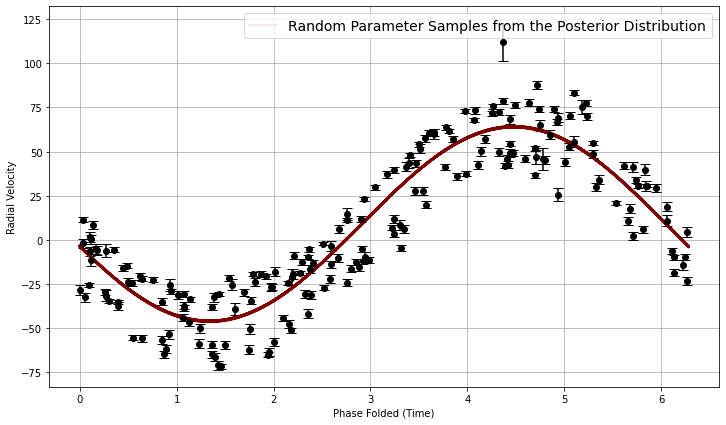

In [12]:
plotter(sampler)

We can see that our perfectly fits our data. Also, the thousand samples drawn from the posteriors seem to overlap over each other quite well.


In [13]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]
samples = sampler.flatchain

<ipython-input-15-18d6e5ad5d08>:3: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.errorbar(2*np.pi*x_data,Rad_Vel, RV_Error, color='black', fmt='o', capsize=5, capthick=1, ecolor='black')


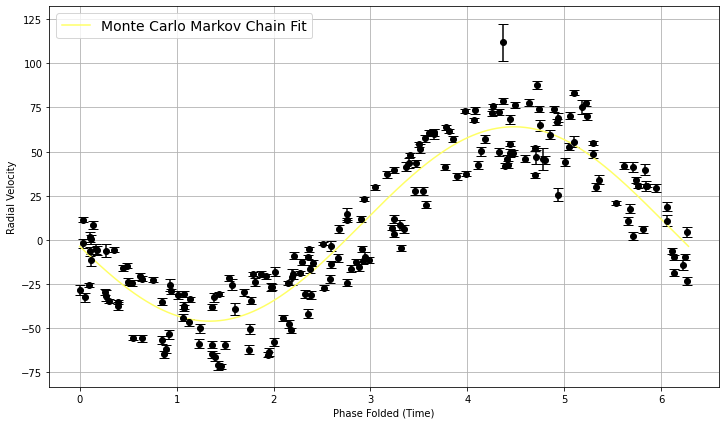

In [15]:
theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model_mcmc = rvmodel_mcmc(theta_max)
plt.errorbar(2*np.pi*x_data,Rad_Vel, RV_Error, color='black', fmt='o', capsize=5, capthick=1, ecolor='black')
plt.plot(2*np.pi*x_model,best_fit_model_mcmc,color='#FFFF66', label="Monte Carlo Markov Chain Fit")
plt.xlabel('Phase Folded (Time)')
plt.ylabel('Radial Velocity')
plt.legend(fontsize=14)
plt.grid()
plt.show()

### Posterior Spread
The corner.py module is used to visualize 1D and 2D spreads between the tested parameters and to obtain the uncertainties on the parameter estimations.

In [16]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    Param = flattened_chain[draw]
    for l in Param:
        mod = rvmodel_mcmc(l)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(1000,samples)

<ipython-input-19-4eb4f8ea7a76>:1: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.errorbar(2*np.pi*x_data,Rad_Vel, RV_Error, color='black', fmt='o', capsize=5, capthick=1, ecolor='black')


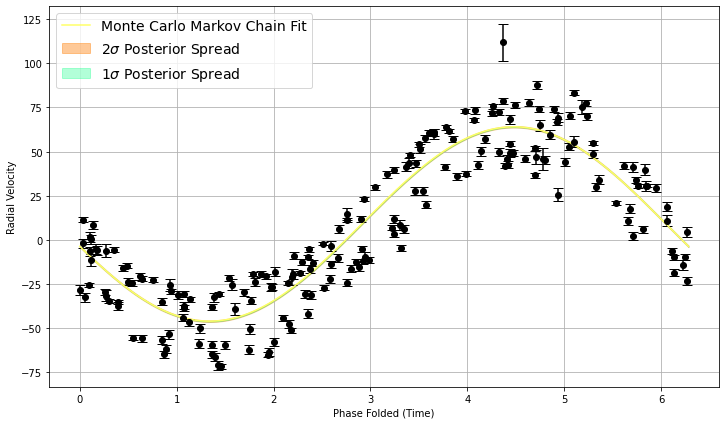

In [19]:
plt.errorbar(2*np.pi*x_data,Rad_Vel, RV_Error, color='black', fmt='o', capsize=5, capthick=1, ecolor='black')
plt.fill_between(2*np.pi*x_model,med_model-2*spread,med_model+2*spread,color='#FE891B',alpha=0.45,label=r'$2\sigma$ Posterior Spread')
plt.fill_between(2*np.pi*x_model,med_model-spread,med_model+spread,color='#00FF7F',alpha=0.3,label=r'$1\sigma$ Posterior Spread')
plt.plot(2*np.pi*x_model,best_fit_model_mcmc,color='#FFFF66', label="Monte Carlo Markov Chain Fit")
plt.xlabel('Phase Folded (Time)')
plt.ylabel('Radial Velocity')
plt.legend(fontsize=14)
plt.grid()
plt.show()

Uncertainties based on the 16th, 50th, and 84th percentiles of the samples in the marginalized distributions


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Parameters based on the Highest Likelihood Model with data from the Posterior Distribution


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<ipython-input-20-eb598e152d4a>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


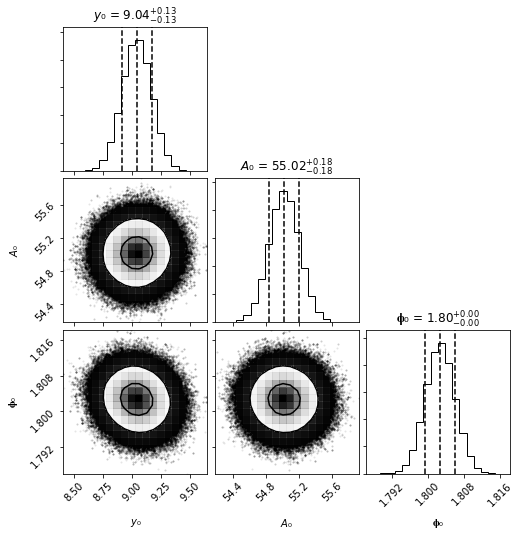

In [20]:
labels = ['$y₀$', '$A₀$', '$𝛟₀$']
label = ['y₀', 'A₀', '𝛟₀']
print('\033[1m' + 'Uncertainties based on the 16th, 50th, and 84th percentiles of the samples in the marginalized distributions' + '\033[0m')

for m in range(ndim):
    mcmc = np.percentile(samples[:, m], [16, 50, 84])
    q = np.diff(mcmc)
    txt1 = "\mathrm{{{3}}} = {0:.9f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt1 = txt1.format(mcmc[1], q[0], q[1], label[m])
    display(Math(txt1))

print('\033[1m' + 'Parameters based on the Highest Likelihood Model with data from the Posterior Distribution' + '\033[0m')

for m in range(ndim):
    txt2 = "\mathrm{{{1}}} = {0:.9f}"
    txt2 = txt2.format(theta_max[m], label[m])
    display(Math(txt2))
fig = corner.corner(samples,show_titles=True,labels=labels,smooth=True,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84],levels=(1-np.exp(-0.5),1-np.exp(-0.5*4)))
fig.show()

The most likely model doesn't always lie at the center of this spread - the spread is around the median model, but the one that absolutely maximizes the likelihood might lie at the edge or even outside this region.

**Developed and designed by [Shubhonkar Paramanick](https://github.com/Shubhonkar-Paramanick)**